In [3]:
import time
import numpy as np
from Cpp_code.former_class_cpp import FormerGame as FormerGameCpp
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque


Python implementation:

In [4]:

############################################################################################################
# Game class implementation
############################################################################################################
class FormerGamePython:
    """
    This class is the game implemented in Python, which is not used at all except for to compare to the C++ implementation.
    """
    def __init__(self, M=9, N=7, S=4, custom_board=None):
        self.M, self.N, self.S = M, N, S
        self.board = custom_board if custom_board is not None else self.create_board()
        
    def create_board(self):
        return np.random.randint(0, self.S, (self.M, self.N), dtype=np.int32)
    
    def get_board(self):
        return np.copy(self.board)
    
    def find_group(self, point):
        return FormerGamePython.find_group_static(self.board, point)
    
    def get_groups(self):
        return FormerGamePython.get_groups_static(self.board)
    
    def get_valid_turns(self):
        return FormerGamePython.get_valid_turns_static(self.board)
    
    def remove_group(self, group):
        for x, y in group:
            self.board[x, y] = -1
    
    def drop_board(self):
        for col in range(self.board.shape[1]):
            column_data = self.board[:, col]
            non_negative = column_data[column_data != -1]
            num_empty = self.board.shape[0] - len(non_negative)
            self.board[:, col] = np.concatenate((np.full(num_empty, -1, dtype=self.board.dtype), non_negative))
    
    def make_turn(self, point):
        group = self.find_group(point)
        self.remove_group(group)
        self.drop_board()
    
    def is_game_over(self):
        return np.all(self.board == -1)
    
    @staticmethod
    def find_group_static(board, point):
        group = set()
        queue = deque([point])
        x, y = point
        target_value = board[x, y]
        while queue:
            cx, cy = queue.popleft()
            if (cx, cy) in group:
                continue
            group.add((cx, cy))
            for nx, ny in [(cx-1, cy), (cx+1, cy), (cx, cy-1), (cx, cy+1)]:
                if 0 <= nx < board.shape[0] and 0 <= ny < board.shape[1]:
                    if board[nx, ny] == target_value and (nx, ny) not in group:
                        queue.append((nx, ny))
        return group

    @staticmethod
    def get_groups_static(board):
        groups = []
        visited = np.full(board.shape, False, dtype=bool)
        for x in range(board.shape[0]):
            for y in range(board.shape[1]):
                if board[x, y] != -1 and not visited[x, y]:
                    group = FormerGame.find_group_static(board, (x, y))
                    groups.append(group)
                    for gx, gy in group:
                        visited[gx, gy] = True
        return groups

    @staticmethod
    def get_valid_turns_static(board):
        valid_turns = []
        visited = np.full(board.shape, False, dtype=bool)
        for row in range(board.shape[0]):
            for col in range(board.shape[1]):
                if board[row, col] != -1 and not visited[row, col]:
                    group = FormerGame.find_group_static(board, (row, col))
                    valid_turns.append((row, col))
                    for gx, gy in group:
                        visited[gx, gy] = True
        return valid_turns

    @staticmethod
    def remove_group_static(board, group):
        new_board = board.copy()
        for x, y in group:
            new_board[x, y] = -1
        return new_board

    @staticmethod
    def drop_board_static(board):
        new_board = board.copy()
        for col in range(board.shape[1]):
            column_data = new_board[:, col]
            non_negative = column_data[column_data != -1]
            num_empty = board.shape[0] - len(non_negative)
            new_board[:, col] = np.concatenate((np.full(num_empty, -1, dtype=board.dtype), non_negative))
        return new_board

    @staticmethod
    def apply_turn_static(board, point):
        group = FormerGame.find_group_static(board, point)
        board_after_removal = FormerGame.remove_group_static(board, group)
        new_board = FormerGame.drop_board_static(board_after_removal)
        return new_board
    
    @staticmethod
    def is_game_over_static(board):
        return np.all(board == -1)



In [21]:
def simulate_game(game):
    """Simulate a full game using random valid moves until game over.
    
    Returns:
        steps (int): Number of moves made.
    """
    steps = 0
    while not game.is_game_over():
        valid_moves = game.get_valid_turns()
        if not valid_moves:
            break
        # Pick a random move (using randint rather than np.random.choice for lists)
        idx = np.random.randint(len(valid_moves))
        move = valid_moves[idx]
        game.make_turn(move)
        steps += 1
    return steps

def runtime_comparison(num_runs, save_results=False):
    M, N, S = 9, 7, 4
    times_python = np.zeros(num_runs, dtype=np.float64)
    times_cpp = np.zeros(num_runs, dtype=np.float64)
    
    # Generate random boards and iterate over all of them
    boards = np.random.randint(0, S, size=(num_runs, M, N), dtype=np.int32)
    for i in range(num_runs):
        board = boards[i]
        
        # Python
        game_py = FormerGamePython(M, N, S, custom_board=board.copy())
        start_py = time.perf_counter()
        steps_py = simulate_game(game_py)
        end_py = time.perf_counter()
        time_py = end_py - start_py
        times_python[i] = time_py

        # C++
        game_cpp = FormerGameCpp(M, N, S, custom_board=board.copy())
        start_cpp = time.perf_counter()
        steps_cpp = simulate_game(game_cpp)
        end_cpp = time.perf_counter()
        time_cpp = end_cpp - start_cpp
        times_cpp[i] = time_cpp
    
    print(f"\nAverage Python time: {np.mean(times_python)} seconds")
    print(f"Average C++ time: {np.mean(times_cpp)} seconds")
    
    if save_results:
        results = pd.DataFrame({
            'run': np.arange(num_runs),
            'python_time': times_python,
            'cpp_time': times_cpp,
        })
        results.to_csv('other/game_simulation_results.csv', index=False)
        print("Results saved to other/game_simulation_results.csv")
    
runtime_comparison(num_runs=100_000, save_results=True)



Average Python time: 0.0021426737474195398 seconds
Average C++ time: 0.0002776545208871175 seconds
Results saved to other/game_simulation_results.csv


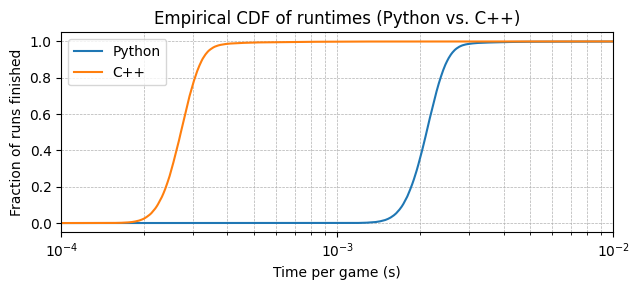

In [ ]:
df = pd.read_csv('other/game_simulation_results.csv')
times_py  = np.sort(df['python_time'].values)
times_cpp = np.sort(df['cpp_time'].values)
n = len(times_py)

# Create a fine grid of x-values between 1e-4 and 1e-2
x_vals = np.logspace(-4, -2, 1000)

# Compute empirical CDFs for both Python and C++
y_py  = np.searchsorted(times_py,  x_vals, side='right') / n
y_cpp = np.searchsorted(times_cpp, x_vals, side='right') / n

# Plot empirical CDFs
plt.figure(figsize=(6.5, 3))
plt.plot(x_vals, y_py,  label='Python', linewidth=1.5)
plt.plot(x_vals, y_cpp, label='C++',   linewidth=1.5)

plt.xscale('log')
plt.xlim(1e-4, 1e-2)
plt.ylim(-0.05, 1.05)

plt.xlabel("Time per game (s)")
plt.ylabel("Fraction of runs finished")
plt.title("Empirical CDF of runtimes (Python vs. C++)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

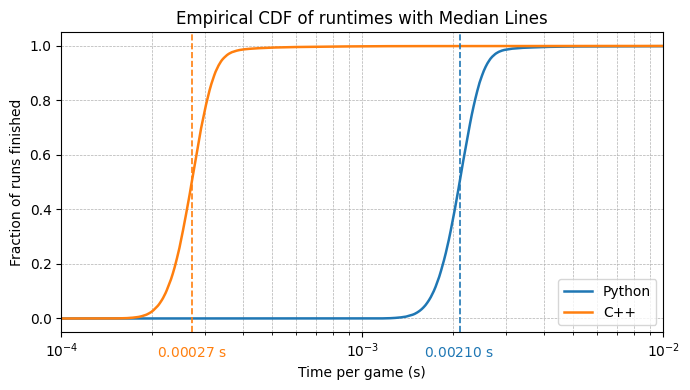

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your CSV of runtimes
df = pd.read_csv('other/game_simulation_results.csv')
times_py  = np.sort(df['python_time'].values)
times_cpp = np.sort(df['cpp_time'].values)
n = len(times_py)

# 1. Compute medians
median_py  = np.median(times_py)
median_cpp = np.median(times_cpp)

# 2. Create a fine grid of x-values between 1e-4 and 1e-2
x_vals = np.logspace(-4, -2, 1000)

# 3. Compute empirical CDFs
y_py  = np.searchsorted(times_py,  x_vals, side='right') / n
y_cpp = np.searchsorted(times_cpp, x_vals, side='right') / n

# 4. Set up the figure and axes
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_vals, y_py,  label='Python', color='C0', linewidth=1.8)
ax.plot(x_vals, y_cpp, label='C++',    color='C1', linewidth=1.8)

# 5. Draw vertical dashed lines at the medians
ax.axvline(median_py,  color='C0', linestyle='--', linewidth=1.2)
ax.axvline(median_cpp, color='C1', linestyle='--', linewidth=1.2)

# 6. Place median values below the x-axis
#    Use axis-transform so y = 0 is at the x-axis, and negative moves below
ax.text(
    median_py, 
    -0.045, 
    f"${median_py:.5f}$ s", 
    transform=ax.get_xaxis_transform(), 
    ha='center', 
    va='top', 
    color='C0'
)
ax.text(
    median_cpp, 
    -0.045, 
    f"${median_cpp:.5f}$ s", 
    transform=ax.get_xaxis_transform(), 
    ha='center', 
    va='top', 
    color='C1'
)

# 7. Final styling
ax.set_xscale('log')
ax.set_xlim(1e-4, 1e-2)
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("Time per game (s)")
ax.set_ylabel("Fraction of runs finished")
ax.set_title("Empirical CDF of runtimes with Median Lines")
ax.legend(loc='lower right')

# Extend bottom margin to make space for the labels
plt.subplots_adjust(bottom=0.18)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()